<a href="https://colab.research.google.com/github/LeonMilosevic/e-bay_phone_evaluator/blob/main/phone_evaluator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## E-bay Phone Evaluator

### Steps to take:

- ##### We will scrape data from ebay with a custom ebay scraper class found here: https://github.com/LeonMilosevic/ebay-phone-scraper
- ##### We will create functions to help us clean our data
- ##### We will perform EDA on our data
- ##### We will create a baseline model
- ##### We will export the model and use it for our Flask API to enable the app for usage, <br /> you can find it here: https://github.com/LeonMilosevic/ebay_phone_price_predictor_api

## Data Scraping

#### Install the package from github

In [ ]:
!pip install git+https://github.com/LeonMilosevic/ebay-phone-scraper

  Cloning https://github.com/LeonMilosevic/ebay-phone-scraper to /tmp/pip-req-build-fepy5ik4
  Running command git clone -q https://github.com/LeonMilosevic/ebay-phone-scraper /tmp/pip-req-build-fepy5ik4
  Created wheel for scraper: filename=scraper-0.1-cp36-none-any.whl size=4290 sha256=e0e480a1213b589148b7606c1ed44385c1f6b29756f97965621abf8128456381
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3bzps9i/wheels/e0/9c/f4/74163fdb13fb9c07070ef9aa7bf028f17b40676e8317a5de92
Successfully built scraper


#### Installing necessery packages to use ebay-phone-scraper

In [ ]:
!pip install fake-useragent

In [ ]:
!pip install pytest ipython_pytest

#### Testing the package

In [ ]:
import ipython_pytest
%load_ext ipython_pytest

In [ ]:
%%pytest
from scraper import scraper
from fake_useragent import UserAgent
import pandas as pd
import pytest

def test_check_conditionNew():
  result = scraper.check_condition("new")
  print(result)
  assert result == 1000

def test_check_conditionUsed():
  result = scraper.check_condition('used')

  assert result == 3000

def test_check_conditionError():
    with pytest.raises(ValueError):
        scraper.check_condition('something else')

def test_calculate_number_of_pages():
    result = scraper.calculate_number_of_pages(48)

    assert result == 1

def test_create_datafrmae():
  brand = "Apple"
  phone_price = ['123', '456', '789']
  phone_model = ['galaxy', 'iphone 7', 'iphone 8']
  phone_ram = ['3 gb', '4gb', '5gb']
  phone_storage = ['64gb', '128gb', '16gb']
  phone_processor = ['some processor', 'some processor2', 'some processor3']
  phone_camera = ['16', '8', '12']
  condition = 0

  result = scraper.create_dataframe(
    brand=brand, 
    condition=condition,
    phone_price=phone_price, 
    phone_model=phone_model, 
    phone_ram=phone_ram, 
    phone_storage=phone_storage, 
    phone_processor=phone_processor, 
    phone_camera=phone_camera
    )
  assert type(result) == pd.DataFrame

============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-3.6.4, py-1.10.0, pluggy-0.7.1
rootdir: /tmp/tmp7x5xmgei, inifile:
plugins: typeguard-2.7.1
collected 5 items

_ipytesttmp.py .....                                                     [100%]

=========================== 5 passed in 0.44 seconds ===========================


## Imports to be used

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Wrangling functions

In [ ]:
# defining functions to be used
def combine_data(list_of_dataframes: list) -> pd.DataFrame:
  """ 
  Joins passed list of dataframes
  
  Arg:
    list_of_dataframes (list)

  returns:
    pd.DataFrame object of passed dataframes
  """
  return pd.concat(list_of_dataframes)

def sum_cameras(df: pd.DataFrame) -> list:
  ''' takes a dataframe, finds cameras with higher str value than 6, sums them and returnes the summed values
      
      args:
            df (pd.DataFrame): dataframe to be operated on

      returns:
            summed_cameras (list): list of summed values passed from the dataframe
  '''
  summed_cameras = []  

  for item in df[df['camera'].str.len() > 6]['camera']:
    result = [x.strip() for x in item.split(',')]
    for i in range(len(result)):
      if result[i] == '8.0.0':
        result[i] = float(8)
      else:
        result[i] = float(result[i])
    summed_cameras.append(sum(result))
  
  return summed_cameras

def rename_phone_model(bad_name_model: str, good_name_model: str, df: pd.DataFrame) -> None:
  """ 
  Renames a given name of the model, with a provided name of the model
  
  Arg:
    bad_name_model (str) : name to be replaced
    good_name_model (str) : name to be replaced with
    df (pd.DataFrame) : dataframe to be cleaned

  returns:
        None
  """
  df[df['model'] == bad_name_model] = good_name_model

def remove_unwanted_models(df: pd.DataFrame, model_name: str) -> None:
  """ 
  Removes given models

  Arg:
    bad_name_model (str) : name to be replaced
    good_name_model (str) : name to be replaced with
    df (pd.DataFrame) : dataframe to be cleaned

  returns:
        None
  """
  models = df[df['model'] == model_name].index

  df.drop(models, inplace=True)

def clean_columns(df: pd.DataFrame, characters: list, column: str, replace_char: str = "") -> pd.DataFrame:
  '''
  Accepts a pd.DataFrame, characters, column. Removes passed characters, returns clean pd.DataFrame

  Arg: df (pd.DataFrame): DataFrame to be cleaned,
       characters (list): list of characters to be removed
       column (str): name of the column to be cleaned
       replace_char (str) : default value is empty, but if specified, can replace the value as well
  returns:
      df (pd.DataFrame): cleaned DataFrame
  '''
  for char in characters:
    df[column] = df[column].str.replace(char, replace_char)

  return df 

def convert_data_to_numeric(df: pd.DataFrame) -> None:
  '''
  Accepts a pd.DataFrame, converts its columns to numeric

  Arg: df (pd.DataFrame): DataFrame to be converted to numeric
  
  returns:
      df (pd.DataFrame): numeric DataFrame
  '''

  df['storage'] = pd.to_numeric(df['storage'])
  df['price'] = pd.to_numeric(df['price'])
  df['camera'] = pd.to_numeric(df['camera'])
  df['ram'] = pd.to_numeric(df['ram'])

def remove_rows_with_false_values(df: pd.DataFrame) -> None:
  '''
  Accepts a pd.DataFrame, removes rows that have same value in each column

  Arg: df (pd.DataFrame): DataFrame to be cleaned
  
  returns:
        None
  '''

  df.drop(df[df['processor'] == df['camera']].index, inplace=True)

def populate_columns_by_model_mean(df: pd.DataFrame) -> None:
  '''
  Accepts a pd.DataFrame, replaces ram memory in each row by model mean value

  Arg: df (pd.DataFrame): DataFrame to be cleaned
  
  returns:
        None
  '''
  models_ram_values = df.groupby('model').agg({'ram': 'mean'})['ram']
  models_camera_values = df.groupby('model').agg({'camera': 'mean'})['camera']
  models_processor_values = df.groupby('model').agg({'processor': pd.Series.mode})['processor']

  for model, value in models_ram_values.items():
    temp_index = df[df['model'] == model].index

    for i in temp_index:
      df.at[i, 'ram'] = value
  
  for model, value in models_camera_values.items():
    temp_index = df[df['model'] == model].index

    for i in temp_index:
      df.at[i, 'camera'] = value

  for model, value in models_processor_values.items():
    if type(value) == np.ndarray:
      pass
    else:
      temp_index = df[df['model'] == model].index

      for i in temp_index:
        df.at[i, 'processor'] = value

def replace_mb_to_gb(df: pd.DataFrame, mb_limit: int, column_name: str) -> None:
  '''
  Accepts a pd.DataFrame, limit to be passed of the mb, name of the column,
  moves decimal by 3 places to convert it from GB to MB

  Arg: 
    df (pd.DataFrame): DataFrame to be cleaned
    mb_limit (int) : limit value that we want for specific column to be searched for
    column_name (str) : name of the column to be transformed from MB to GB
  
  returns:
        None
  '''
  mb = df[df[column_name] > mb_limit][column_name].tolist()
  mb_index = df[df[column_name] > mb_limit].index
  
  converted = [(ram / 1000) for ram in mb]

  for i in range(len(mb_index)):
    df.at[mb_index[i], column_name] = converted[i]

def replace_specific_value(df: pd.DataFrame, original_value: str, new_value: str, column_name) -> None:
  '''
  Accepts a pd.DataFrame, replaces old value with a new value in the specified column

  Arg: 
    df (pd.DataFrame): DataFrame to be changed
    original_value (int) : value we want to replace
    new_value (str, int) : value that will change original_value
    column_name (str) : name of the column that needs to be changed
  
  returns:
        None
  '''
  original_value_idx = df[df[column_name] == original_value].index

  for i in range(len(original_value_idx)):
    df.at[original_value_idx[i], column_name] = new_value

def multi_camera_phones_to_single_value(df: pd.DataFrame) -> None:
  '''
  accepts a dataframe, sums cameras from camera column and replaces their value with summed value

  Arg: 
    df (pd.DataFrame): DataFrame to be changed
  
  returns:
        None
  '''
  cameras_to_be_replaced = df[df['camera'].str.len() > 6].index
  summed_cameras = sum_cameras(df)

  for i in range(len(cameras_to_be_replaced)):
    df.at[cameras_to_be_replaced[i], 'camera'] = summed_cameras[i]

def update_specific_model_ram(model_name: str, ram: int, df: pd.DataFrame) -> None:
  '''
  Accepts a pd.DataFrame, replaces ram memory in for a given model name

  Arg: 
    df (pd.DataFrame): DataFrame to be cleaned
    model_name (str) : name of the model
    ram (int) : value to be updated
  
  returns:
        None
  '''
  model_index = df[df['model'] == model_name].index

  for i in model_index:
    df.at[i, 'ram'] = ram

## Data Wrangling

In [ ]:
apple_new_data = pd.read_csv('Apple_new_data.csv')
apple_used_data = pd.read_csv('Apple_used_data.csv')
huawei_new_data = pd.read_csv('Huawei_new_data.csv')
huawei_used_data = pd.read_csv('Huawei_used_data.csv')
samsung_new_data = pd.read_csv('Samsung_new_data.csv')
samsung_used_data = pd.read_csv('Samsung_used_data.csv')

In [ ]:
# adding condition to data
apple_new_data['condition'] = 'new'
apple_used_data['condition'] = 'used'

huawei_new_data['condition'] = 'new'
huawei_used_data['condition'] = 'used'

samsung_new_data['condition'] = 'new'
samsung_used_data['condition'] = 'used'

In [ ]:
# join dataframes
list_of_df = [apple_new_data,
                 apple_used_data,
                 huawei_new_data,
                 huawei_used_data,
                 samsung_new_data,
                 samsung_used_data]

phone_data = combine_data(list_of_df)

In [ ]:
phone_data.shape

(14853, 8)

In [ ]:
phone_data.isnull().sum()

price        6600
model        8517
ram          8024
storage      8492
processor    8612
camera       8901
brand           0
condition       0
dtype: int64

- Replacable Data: RAM, Processor and Camera resolution.



- Irreplaceable Data: price, model and storage, because we don't know precise sold price of the phone or correct model, as well same models come with different storage regardless of other specifics.


In [ ]:
# dropping rows where price, model and storage is NaN
phone_data = phone_data.dropna(subset=['price', 'model', 'storage'])

The data contains extra characters in columns, we will remove all the string characters and leave only numeric characters

In [ ]:
phone_data = clean_columns(phone_data, ['$', ','], 'price')
phone_data = clean_columns(phone_data, ['GB', 'gb', 'mb', 'MB'], 'storage')
phone_data = clean_columns(phone_data, ['MP', 'mb'], 'camera')
phone_data = clean_columns(phone_data, ['MB', 'GB', 'gb'], 'ram')
phone_data = clean_columns(phone_data, ['+'], 'camera', replace_char=",")

Some phones have differently formated model names, we will manually replace those

In [ ]:
rename_phone_model('5', 'Apple iPhone 5', phone_data)
rename_phone_model('iPhone 6s.', 'Apple iPhone 6s', phone_data)

Some rows as well contain false values, <br />
example: all columns of a row are represented by a value of 1, we will remove those

In [ ]:
remove_rows_with_false_values(phone_data)
phone_data.reset_index(drop=True, inplace=True)

Some models have more than one camera, or camera is named as Vga so we will need to sum the values of them and replace Vga with a numeric value, used internet for Vga value

In [ ]:
multi_camera_phones_to_single_value(phone_data)
replace_specific_value(phone_data, 'Vga', 43, 'camera')

Convert the data to numeric values

In [ ]:
convert_data_to_numeric(phone_data)

Lets rename badly written proccessors

In [ ]:
replace_specific_value(phone_data, 'Quad+Quad Core', 'Quad Core', 'processor')

We will use a function to populate ram and camera missing values by their model mean. Both Apple iPhone 12 Pro Max and Mini had their rams missing, used internet to find value of their rams.

In [ ]:
populate_columns_by_model_mean(phone_data)
update_specific_model_ram('Apple iPhone 12 Pro Max', 6, phone_data)
update_specific_model_ram('Apple iPhone 12 mini', 4, phone_data)

In [ ]:
phone_data.isnull().sum()

price         0
model         0
ram          52
storage       0
processor    40
camera       33
brand         0
condition     0
dtype: int64

We are left with mostly unique models, we could search online and replace manually by hand, but to save time, we will drop those rows with missing value

In [ ]:
phone_data.dropna(inplace=True)

Lets convert MB to GB

In [ ]:
# if there is a model with more than 16 gb ram, we will assume its mb
replace_mb_to_gb(phone_data, 16, 'ram')
replace_mb_to_gb(phone_data, 512, 'storage')

In [ ]:
phone_data.reset_index(drop=True, inplace=True)

## Data EDA

In [ ]:
phone_data.head(5)

,price,model,ram,storage,processor,camera,brand,condition
0,618.41,Apple iPhone XR,3.0,256,Hexa Core,12.0,Apple,new
1,850.00,Apple iPhone 11 Pro,4.0,64,Hexa Core,12.0,Apple,new
2,1534.65,Apple iPhone 12 Pro Max,6.0,256,Hexa Core,12.0,Apple,new
3,1332.11,Apple iPhone 12 Pro Max,6.0,256,Hexa Core,12.0,Apple,new
4,1412.31,Apple iPhone 12 Pro,6.0,128,Hexa Core,12.0,Apple,new


In [ ]:
phone_data['price'].describe()

count    5603.000000
mean      650.917987
std       572.341905
min         4.080000
25%       224.270000
50%       441.770000
75%       951.500000
max      4703.180000
Name: price, dtype: float64

Price feature seems right skewed, 
min is 4,
median is 441, 
max is 4703

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

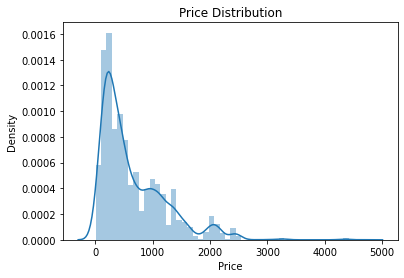

In [ ]:
sns.distplot(phone_data['price'])

plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Density')

- We can try to normalize the distribution later and remove the outliers

Text(0, 0.5, 'Num of Phones')

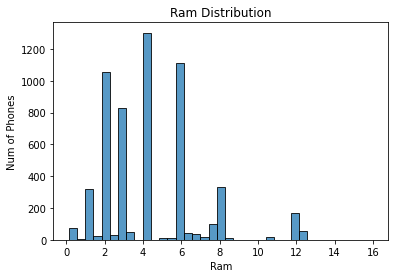

In [ ]:
sns.histplot(phone_data['ram'])

plt.title('Ram Distribution')
plt.xlabel('Ram')
plt.ylabel('Num of Phones')

- We can threat it as a continuos variable

Text(0, 0.5, 'Num of Phones')

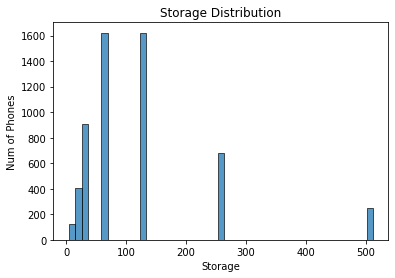

In [ ]:
sns.histplot(phone_data['storage'])

plt.title('Storage Distribution')
plt.xlabel('Storage')
plt.ylabel('Num of Phones')

- We may try to encode storage, but we can also threat it as a continous variable

Text(0, 0.5, 'Num of Phones')

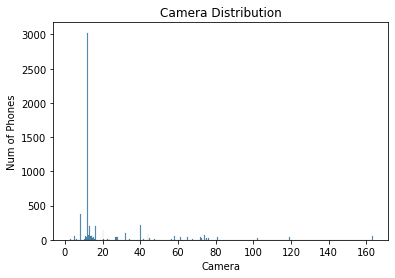

In [ ]:
sns.histplot(phone_data['camera'])

plt.title('Camera Distribution')
plt.xlabel('Camera')
plt.ylabel('Num of Phones')

- Looking at the camera feature, we see that it is right skewed, we may try to bin it in categories or remove the outliers

Lets check number of unique processors that we have

In [ ]:
phone_data['processor'].unique().tolist()

['Hexa Core', 'Dual Core', 'Quad Core', 'Single Core', 'Octa Core']

- We can do ordinal encoding for processor feature

Lets check number of different models

In [ ]:
phone_data['model'].unique().shape

(198,)

- We may try to label encode the model feature, or we can decide to remove the feature later as well

And we have condition column

In [ ]:
phone_data['condition'].unique().tolist()

['new', 'used']

- We will hot-encode this feature

## Modeling

Lets create a baseline model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

In [ ]:
features_to_use = ['brand', 'ram', 'processor', 'condition', 'storage', 'camera']

x_train, x_test, y_train, y_test = train_test_split(
    phone_data[features_to_use],
    phone_data['price'],
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [ ]:
features_to_encode = ['processor', 'brand', 'condition']


preprocessor = ColumnTransformer(
    transformers=[
        ('hot_encode', preprocessing.OneHotEncoder(), features_to_encode),
    ],
    remainder='passthrough'
)

In [ ]:
param_grid = { 
    'model__n_estimators': [100],
    'model__max_features': ['auto', 'log2', 'sqrt'],
    'model__max_depth' : [5, 7, 9, 12, 15, 20]
}

rfr = RandomForestRegressor(random_state=RANDOM_STATE)

In [ ]:
pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', rfr)
    ]
)

In [ ]:
rs_rfr = RandomizedSearchCV(pipe,
                            param_grid,
                            n_iter=15,
                            cv=10,
                            n_jobs=-1,
                            random_state=RANDOM_STATE,
                            scoring='neg_mean_squared_error')

rs_rfr.fit(x_train, y_train)
rs_rfr.best_params_

{'model__max_depth': 12,
 'model__max_features': 'sqrt',
 'model__n_estimators': 100}

In [ ]:
rs_rfr.best_score_ * -1

73380.21840798622

In [ ]:
rfr_final = RandomForestRegressor(max_depth=12, max_features='sqrt', n_estimators=5000)
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', rfr_final)
    ]
)
pipe_final.fit(x_train, y_train)

In [ ]:
y_pred = pipe_final.predict(x_test)
print('Validation mean squared error is', mean_squared_error(y_test, y_pred))

Validation mean squared error is 83757.95937057753


We could do feature engineering, try to normalize the distribution of the price feature, we could remove outliers, add artificial features,try to scrape more information about a specific phone or get more data, but to save time we will export this model.

In [ ]:
import pickle

pickle.dump(pipe_final, open("rfr.pkl", "wb"))

## Testing API

We will test our api to see how it performs

In [ ]:
import requests
import json

resp = requests.post("https://phone-evaluator.herokuapp.com/predict", data=json.dumps(
    {
    "ram": 2.0,
    "storage": 256.0,
    "processor": 2.0,
    "camera": 12.0,
    "brand": "apple",
    "condition": "used"
}
))
print(json.loads(resp.text))

{'evaluation': 214.14714285714288}
